In [3]:
import os
import numpy as np
import tempfile
import pickle
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
import lightning.pytorch as pl


import lightning_uq_box as luq

<h2> Load OCO-2 Soundings </h2>

In [2]:
# load the example pickle file
pkl_str = "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned.p"
data = pickle.load(open(pkl_str, "rb"))

# print the keys of the pickle file
print(data.keys())

# print the shape of the sco2_band
print(len(data["sco2_band"]))

dict_keys(['o2_band', 'wco2_band', 'sco2_band', 'o2_band_no_eof', 'wco2_band_no_eof', 'sco2_band_no_eof', 'o2_band_obs', 'wco2_band_obs', 'sco2_band_obs', 'o2_band_idxs', 'wco2_band_idxs', 'sco2_band_idxs', 'o2_wl', 'wco2_wl', 'sco2_wl', 'num_color', 'states', 'state_var'])
4317


In [4]:
# lets create a new pickle that downsamples the data and saves as a new pickle for local use
pkl_str = "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned.p"
def create_sampled_local_pickle(n_samples, load_path, save_path):
    # create a smaller pickle for working with on local machine
    """Args:
        n_samples (int): number of samples to keep
        load_path (str): path to the pickle file to load
        save_path (str): path to save the downsampled pickle file
    """
    try:
        with open(load_path, 'rb') as file:
            file_data = pickle.load(file)

        # downsample the data
        for key in file_data.keys():
            file_data[key] = file_data[key][:n_samples]
        
        # save the downsampled data
        with open(save_path, 'wb') as file:
            pickle.dump(file_data, file)
    except Exception as e:
        print(e)

# create a new pickle file with 10000 samples
create_sampled_local_pickle(10000, pkl_str, "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned_local.p")

In [5]:
# open the pickle and check the shape of the sco2_band
data = pickle.load(open("/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned_local.p", "rb"))

# print the keys of the pickle file
print(data.keys())

# print the shape of the sco2_band
print(len(data["sco2_band"]))

dict_keys(['o2_band_no_eof', 'sco2_band_no_eof', 'wco2_band_no_eof', 'o2_band_obs', 'sco2_band_obs', 'wco2_band_obs', 'o2_band', 'sco2_band', 'wco2_band', 'o2_band_idxs', 'sco2_band_idxs', 'wco2_band_idxs', 'o2_band_wl', 'sco2_band_wl', 'wco2_band_wl', 'states', 'state_var', 'num_color'])
10000


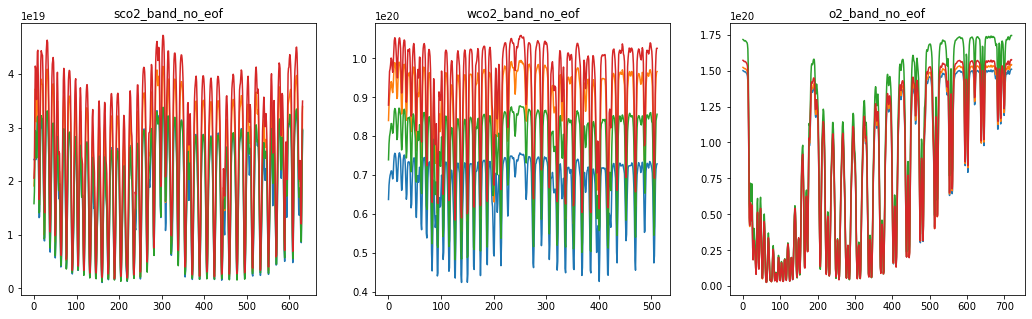

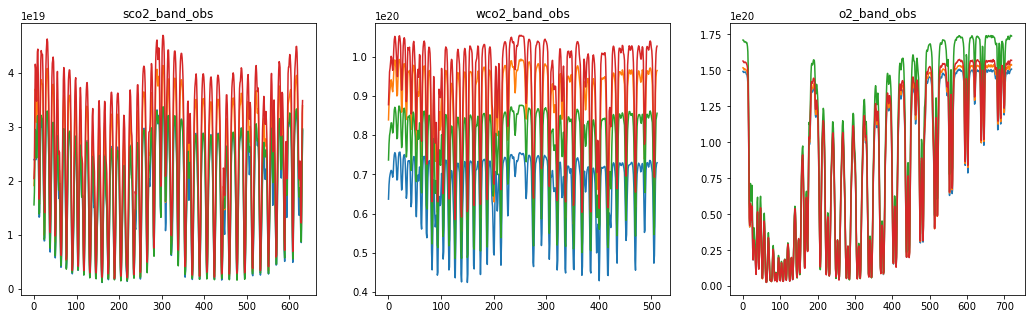

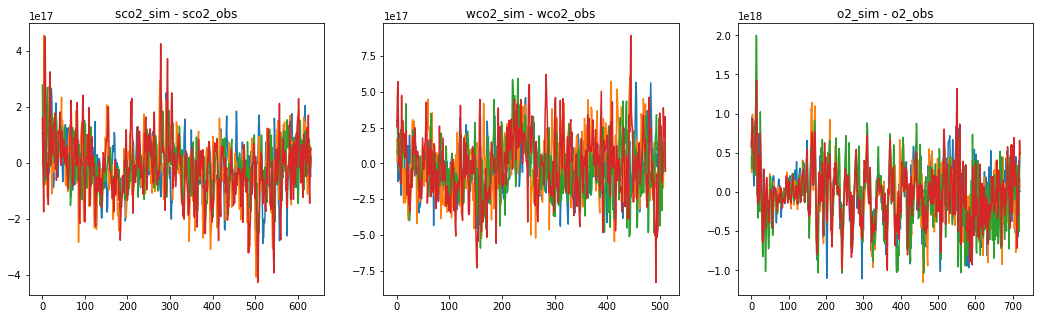

In [6]:
# vizualize the radiances with EOF removed
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_no_eof"][0])
ax[0].plot(data["sco2_band_no_eof"][1000])
ax[0].plot(data["sco2_band_no_eof"][2000])
ax[0].plot(data["sco2_band_no_eof"][4000])
ax[0].set_title("sco2_band_no_eof")

ax[1].plot(data["wco2_band_no_eof"][0])
ax[1].plot(data["wco2_band_no_eof"][1000])
ax[1].plot(data["wco2_band_no_eof"][2000])
ax[1].plot(data["wco2_band_no_eof"][4000])
ax[1].set_title("wco2_band_no_eof")

ax[2].plot(data["o2_band_no_eof"][0])
ax[2].plot(data["o2_band_no_eof"][1000])
ax[2].plot(data["o2_band_no_eof"][2000])
ax[2].plot(data["o2_band_no_eof"][4000])
ax[2].set_title("o2_band_no_eof")

plt.show()

# vizualize the observations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_obs"][0])
ax[0].plot(data["sco2_band_obs"][1000])
ax[0].plot(data["sco2_band_obs"][2000])
ax[0].plot(data["sco2_band_obs"][4000])
ax[0].set_title("sco2_band_obs")

ax[1].plot(data["wco2_band_obs"][0])
ax[1].plot(data["wco2_band_obs"][1000])
ax[1].plot(data["wco2_band_obs"][2000])
ax[1].plot(data["wco2_band_obs"][4000])
ax[1].set_title("wco2_band_obs")

ax[2].plot(data["o2_band_obs"][0])
ax[2].plot(data["o2_band_obs"][1000])
ax[2].plot(data["o2_band_obs"][2000])
ax[2].plot(data["o2_band_obs"][4000])
ax[2].set_title("o2_band_obs")

plt.show()

# vizualize the difference
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(data["sco2_band_no_eof"][0] - data["sco2_band_obs"][0])
ax[0].plot(data["sco2_band_no_eof"][1000] - data["sco2_band_obs"][1000])
ax[0].plot(data["sco2_band_no_eof"][2000] - data["sco2_band_obs"][2000])
ax[0].plot(data["sco2_band_no_eof"][4000] - data["sco2_band_obs"][4000])
ax[0].set_title("sco2_sim - sco2_obs")

ax[1].plot(data["wco2_band_no_eof"][0] - data["wco2_band_obs"][0])
ax[1].plot(data["wco2_band_no_eof"][1000] - data["wco2_band_obs"][1000])
ax[1].plot(data["wco2_band_no_eof"][2000] - data["wco2_band_obs"][2000])
ax[1].plot(data["wco2_band_no_eof"][4000] - data["wco2_band_obs"][4000])
ax[1].set_title("wco2_sim - wco2_obs")

ax[2].plot(data["o2_band_no_eof"][0] - data["o2_band_obs"][0])
ax[2].plot(data["o2_band_no_eof"][1000] - data["o2_band_obs"][1000])
ax[2].plot(data["o2_band_no_eof"][2000] - data["o2_band_obs"][2000])
ax[2].plot(data["o2_band_no_eof"][4000] - data["o2_band_obs"][4000])
ax[2].set_title("o2_sim - o2_obs")

plt.show()




<h2>Lightning Data Loader </h2>

In [80]:
# define the Lightning DataSet for Xgas retrieval
from torch.utils.data import Dataset
class RetrievalDataSet(Dataset):
    '''OCO-2 DataSet for Xgas retrieval'''
    def __init__(self, files, train=True, normalize=True, use_convolutions=False, transform=None, normalize_file='normalize.pkl'):
        self.files = files
        self.train = train
        self.normalize = normalize
        self.transform = transform
        self.normalize_file = normalize_file
        self.use_convolutions = use_convolutions
        
        # Load data based on the file paths
        self.X, self.y = self.load_data()

    def load_data(self):
        sco2 = []
        wco2 = []
        o2 = []
        y = []
        
        for file_path in self.files:
            try:
                with open(file_path, 'rb') as file:
                    file_data = pickle.load(file)
                    
                    if self.train:
                        sco2.append(file_data['sco2_band_no_eof'])
                        wco2.append(file_data['wco2_band_no_eof'])
                        o2.append(file_data['o2_band_no_eof'])
                    else:
                        sco2.append(file_data['sco2_band_obs'])
                        wco2.append(file_data['wco2_band_obs'])
                        o2.append(file_data['o2_band_obs'])
                    xco2_idx = file_data['state_var'].index('RetrievalResults/xco2')
                    xco2_values = [state[xco2_idx] for state in file_data['states']]
                    y.append(xco2_values)
            except (FileNotFoundError, KeyError, pickle.UnpicklingError) as e:
                print(f"Error loading file {file_path}: {e}")


        
        if self.normalize:
            if not self.train:
                with open(self.normalize_file, 'rb') as file:
                    norm_params = pickle.load(file)
                sco2 = (sco2 - norm_params['sco2_mean']) / norm_params['sco2_std']
                wco2 = (wco2 - norm_params['wco2_mean']) / norm_params['wco2_std']
                o2 = (o2 - norm_params['o2_mean']) / norm_params['o2_std']
                y = (y - norm_params['targets_mean']) / norm_params['targets_std']
                # squeez the data
                sco2 = np.squeeze(sco2)
                wco2 = np.squeeze(wco2)
                o2 = np.squeeze(o2)
                y = np.squeeze(y)
                # concat sco2, wco2, and o2
                X = np.concatenate([o2, wco2, sco2], axis = 1)
                # remove any rows with nans
                mask = np.isnan(X).any(axis=1)
                X = X[~mask]
                y = y[~mask]
                X = torch.tensor(X, dtype=torch.float32)
                y = torch.tensor(y, dtype=torch.float32)

            else:
                sco2_mean = np.nanmean(sco2)
                sco2_std = np.nanstd(sco2)
                wco2_mean = np.nanmean(wco2)
                wco2_std = np.nanstd(wco2)
                o2_mean = np.nanmean(o2)
                o2_std = np.nanstd(o2)
                targets_mean = np.nanmean(y)
                targets_std = np.nanstd(y)
                sco2 = (sco2 - sco2_mean) / sco2_std
                wco2 = (wco2 - wco2_mean) / wco2_std
                o2 = (o2 - o2_mean) / o2_std
                y = (y - targets_mean) / targets_std
                # squeez the data
                sco2 = np.squeeze(sco2)
                wco2 = np.squeeze(wco2)
                o2 = np.squeeze(o2)
                y = np.squeeze(y)
                # concat sco2, wco2, and o2
                X = np.concatenate([o2, wco2, sco2], axis = 1)
                # remove any rows with nans
                mask = np.isnan(X).any(axis=1)
                X = X[~mask]
                y = y[~mask]
                # make X a torch tensor
                X = torch.tensor(X, dtype=torch.float32)
                y = torch.tensor(y, dtype=torch.float32)
                with open(self.normalize_file, 'wb') as file:
                    pickle.dump({'sco2_mean': sco2_mean, 'sco2_std': sco2_std,
                                 'wco2_mean': wco2_mean, 'wco2_std': wco2_std,
                                 'o2_mean': o2_mean, 'o2_std': o2_std,
                                 'targets_mean': targets_mean, 'targets_std': targets_std}, file)


        print(X.shape)
        assert X.shape[0] == y.shape[0], "Data lengths do not match"
        y = y.unsqueeze(-1)
        # if use_convolutions is True, reshape the data to [1, number of samples, number of features]
        if self.use_convolutions:
            X = X.unsqueeze(0)
            y = y.unsqueeze(0)


        return X, y

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx) -> Tensor:
        X = self.X[idx]
        y = self.y[idx]
        
        sample = {'input': X, 'target': y}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
# TODO : Filter soudnings by outcome_flag; 0 for training, no filtering for training
class SimDiffDataSet(Dataset):
    '''OCO-2 DataSet for making retrieval robust to sim - obs differences'''
    def __init__(self, band, files, train=True, normalize=True, use_convolutions=False, transform=None, normalize_file='sim_diff_normalize.pkl', scaled_eof=False):
        """Args:
            band: The band to use X and y. Options are 'sco2', 'wco2', 'o2'
            files: The list of file paths
            train: If True, use the training data
            normalize: If True, normalize the data
            transform: The transform to apply to the data
            normalize_file: The file to save the normalization parameters
            scaled_eof: If True, use scaled the EOFs
            use_convolutions: If True, reshape the data to [1, number of samples, number of features]
        """
        self.band = band
        self.files = files
        self.train = train
        self.normalize = normalize
        self.transform = transform
        self.normalize_file = normalize_file
        self.use_convolutions = use_convolutions
        self.scaled_eof = scaled_eof
        
        # Load data based on the file paths
        self.X, self.y = self.load_data()

    def load_data(self):
        sco2 = []
        wco2 = []
        o2 = []
        y = []
        
        for file_path in self.files:
            try:
                with open(file_path, 'rb') as file:
                    file_data = pickle.load(file)
                    
                    if self.train:
                        sco2.append(file_data['sco2_band_obs'])
                        wco2.append(file_data['wco2_band_obs'])
                        o2.append(file_data['o2_band_obs'])
                        sco2 = np.squeeze(sco2)
                        wco2 = np.squeeze(wco2)
                        o2 = np.squeeze(o2)
                    else:
                        sco2.append(file_data['sco2_band_obs'])
                        wco2.append(file_data['wco2_band_obs'])
                        o2.append(file_data['o2_band_obs'])
                        sco2 = np.squeeze(sco2)
                        wco2 = np.squeeze(wco2)
                        o2 = np.squeeze(o2)
                    if self.scaled_eof:
                        y_sco2 = np.array(file_data['sco2_band']) - np.array(file_data['sco2_band_obs'])
                        y_wco2 = np.array(file_data['wco2_band']) - np.array(file_data['wco2_band_obs'])
                        y_o2 = np.array(file_data['o2_band']) - np.array(file_data['o2_band_obs'])
                        self.normalize_file = 'scaled_eof_sim_diff_normalize.pkl'
                    else:
                        y_sco2 = np.array(file_data['sco2_band_no_eof']) - np.array(file_data['sco2_band_obs'])
                        y_wco2 = np.array(file_data['wco2_band_no_eof']) - np.array(file_data['wco2_band_obs'])
                        y_o2 = np.array(file_data['o2_band_no_eof']) - np.array(file_data['o2_band_obs'])
            except (FileNotFoundError, KeyError, pickle.UnpicklingError) as e:
                print(f"Error loading file {file_path}: {e}")




        if not self.train:
            if self.normalize:
                with open(self.normalize_file, 'rb') as file:
                    norm_params = pickle.load(file)
                sco2 = (sco2 - norm_params['sco2_mean']) / norm_params['sco2_std']
                wco2 = (wco2 - norm_params['wco2_mean']) / norm_params['wco2_std']
                o2 = (o2 - norm_params['o2_mean']) / norm_params['o2_std']
                y_sco2 = (y_sco2 - norm_params['y_sco2_mean']) / norm_params['y_sco2_std']
                y_wco2 = (y_wco2 - norm_params['y_wco2_mean']) / norm_params['y_wco2_std']
                y_o2 = (y_o2 - norm_params['y_o2_mean']) / norm_params['y_o2_std']
            # squeez the data
            sco2 = np.squeeze(sco2)
            wco2 = np.squeeze(wco2)
            o2 = np.squeeze(o2)
            y_sco2 = np.squeeze(y_sco2)
            y_wco2 = np.squeeze(y_wco2)
            y_o2 = np.squeeze(y_o2)
            # concat sco2, wco2, and o2
            # X = np.concatenate([o2, wco2, sco2], axis = 1)
            # y = np.concatenate([y_o2, y_wco2, y_sco2], axis = 1)
            if self.band == 'sco2':
                X = sco2
                y = y_sco2
            elif self.band == 'wco2':
                X = wco2
                y = y_wco2
            elif self.band == 'o2':
                X = o2
                y = y_o2
            X = torch.tensor(X, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            if self.use_convolutions:
                X = X.unsqueeze(0)
                y = y.unsqueeze(0)
                X = X.permute(1, 0, 2)
                y = y.permute(1, 0, 2)

            assert X.shape[0] == y.shape[0], "Data lengths do not match"
            return X, y

        else:
            # filter by outcome_flag == 1
            idx = file_data['state_var'].index('RetrievalResults/outcome_flag')
            outcome_mask = file_data['states'][:, idx] == 1
            sco2_filt = [sco2[i] for i in range(len(sco2)) if outcome_mask[i]]
            wco2_filt = [wco2[i] for i in range(len(wco2)) if outcome_mask[i]]
            o2_filt = [o2[i] for i in range(len(o2)) if outcome_mask[i]]
            y_sco2_filt = [y_sco2[i] for i in range(len(y_sco2)) if outcome_mask[i]]
            y_wco2_filt = [y_wco2[i] for i in range(len(y_wco2)) if outcome_mask[i]]
            y_o2_filt = [y_o2[i] for i in range(len(y_o2)) if outcome_mask[i]]

            if self.normalize:
                sco2_mean = np.nanmean(sco2_filt)
                sco2_std = np.nanstd(sco2_filt)
                wco2_mean = np.nanmean(wco2_filt)
                wco2_std = np.nanstd(wco2_filt)
                o2_mean = np.nanmean(o2_filt)
                o2_std = np.nanstd(o2_filt)
                y_sco2_mean = np.nanmean(y_sco2_filt)
                y_sco2_std = np.nanstd(y_sco2_filt)
                y_wco2_mean = np.nanmean(y_wco2_filt)
                y_wco2_std = np.nanstd(y_wco2_filt)
                y_o2_mean = np.nanmean(y_o2_filt)
                y_o2_std = np.nanstd(y_o2_filt)
                sco2_filt = (sco2_filt - sco2_mean) / sco2_std
                wco2_filt = (wco2_filt - wco2_mean) / wco2_std
                o2_filt = (o2_filt - o2_mean) / o2_std
                y_sco2_filt = (y_sco2_filt - y_sco2_mean) / y_sco2_std
                y_wco2_filt = (y_wco2_filt - y_wco2_mean) / y_wco2_std
                y_o2_filt = (y_o2_filt - y_o2_mean) / y_o2_std

                with open(self.normalize_file, 'wb') as file:
                    pickle.dump({'sco2_mean': sco2_mean, 'sco2_std': sco2_std,
                                    'wco2_mean': wco2_mean, 'wco2_std': wco2_std,
                                    'o2_mean': o2_mean, 'o2_std': o2_std,
                                    'y_sco2_mean' : y_sco2_mean, 'y_sco2_std' : y_sco2_std,
                                    'y_wco2_mean' : y_wco2_mean, 'y_wco2_std' : y_wco2_std,
                                    'y_o2_mean' : y_o2_mean, 'y_o2_std' : y_o2_std},
                            file)
                    


                
                



            # concat sco2, wco2, and o2
            # X = np.concatenate([o2, wco2, sco2], axis = 1)
            # y = np.concatenate([y_o2, y_wco2, y_sco2], axis = 1)
            # make X a torch tensor
            if self.band == 'sco2':
                X = sco2_filt
                y = y_sco2_filt
            elif self.band == 'wco2':
                X = wco2_filt
                y = y_wco2_filt
            elif self.band == 'o2':
                X = o2_filt
                y = y_o2_filt
            X = torch.tensor(X, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            if self.use_convolutions:
                X = X.unsqueeze(0)
                y = y.unsqueeze(0)
                X = X.permute(1, 0, 2)
                y = y.permute(1, 0, 2)
            print(X.shape)
            print(y.shape)
            assert X.shape[0] == y.shape[0], "Data lengths do not match"
            return X, y
    # if use_convolutions is True, reshape the data to [1, number of samples, number of features]



        

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx) -> Tensor:
        X = self.X[idx]
        y = self.y[idx]
        
        sample = {'input': X, 'target': y}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

class RetrievalDataModule(pl.LightningDataModule):
    """DataModule for OCO Xgas retrieval."""
    def __init__(self, train_files, val_files, test_files, batch_size=32, use_convolutions = False,  normalize_file='normalize.pkl'):
        super().__init__()
        """Args:
            train_files: The list of training file paths
            val_files: The list of validation file paths
            test_files: The list of test file paths
            batch_size: The batch size for the DataLoader
            num_workers: The number of workers for the DataLoader
            use_convolutions: If True, reshape the data to [1, number of samples, number of features]
            normalize_file: The file to save the normalization parameters
        """
        self.train_files = train_files
        self.val_files = val_files
        self.test_files = test_files
        self.batch_size = batch_size
        self.use_convolutions = use_convolutions
        self.normalize_file = normalize_file

        self.train_dataset = RetrievalDataSet(self.train_files, train=True, normalize=True, use_convolutions=self.use_convolutions, normalize_file=self.normalize_file)
        self.X_train, self.Y_train = self.train_dataset.X, self.train_dataset.y
        self.val_dataset = RetrievalDataSet(self.val_files, train=True, normalize=True, use_convolutions=self.use_convolutions,normalize_file=self.normalize_file)
        self.X_val, self.Y_val = self.val_dataset.X, self.val_dataset.y
        self.test_dataset = RetrievalDataSet(self.test_files, train=False, normalize=True, use_convolutions=self.use_convolutions,normalize_file=self.normalize_file)
        self.X_test, self.Y_test = self.test_dataset.X, self.test_dataset.y


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, )
    
# TODO : Filter soudnings by outcome_flag; 0 for training, no filtering for training
class SimDiffDataModule(pl.LightningDataModule):
    """DataModule for OCO sim - obs differences."""
    def __init__(self, band, train_files, val_files, test_files, batch_size=32, use_convolutions = False, scaled_eof = False, normalize_file='normalize.pkl'):
        super().__init__()
        """Args:
            band: The band to use X and y. Options are 'sco2', 'wco2', 'o2'
            train_files: The list of training file paths
            val_files: The list of validation file paths
            test_files: The list of test file paths
            batch_size: The batch size for the DataLoader
            num_workers: The number of workers for the DataLoader
            use_convolutions: If True, reshape the data to [1, number of samples, number of features]
            scaled_eof: If True, use scaled the EOFs
            normalize_file: The file to save the normalization parameters
        """
        self.band = band
        self.train_files = train_files
        self.val_files = val_files
        self.test_files = test_files
        self.batch_size = batch_size
        self.use_convolutions = use_convolutions
        self.scaled_eof = scaled_eof
        self.normalize_file = normalize_file

        self.train_dataset = SimDiffDataSet(self.band, self.train_files, train=True, normalize=True, use_convolutions=self.use_convolutions, scaled_eof= self.scaled_eof,normalize_file=self.normalize_file)
        self.X_train, self.Y_train = self.train_dataset.X, self.train_dataset.y
        self.val_dataset = SimDiffDataSet(self.band, self.val_files, train=True, normalize=True, use_convolutions=self.use_convolutions,scaled_eof= self.scaled_eof,normalize_file=self.normalize_file)
        self.X_val, self.Y_val = self.val_dataset.X, self.val_dataset.y
        self.test_dataset = SimDiffDataSet(self.band, self.test_files, train=False, normalize=True, use_convolutions=self.use_convolutions,scaled_eof= self.scaled_eof,normalize_file=self.normalize_file)
        self.X_test, self.Y_test = self.test_dataset.X, self.test_dataset.y


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, )








torch.Size([9872, 1864])


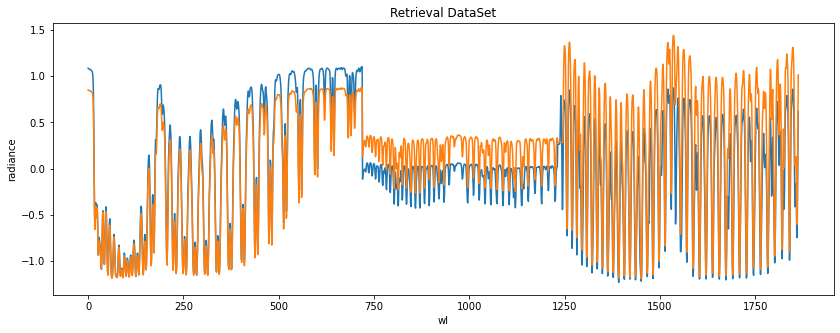

torch.Size([3351, 1, 632])
torch.Size([3351, 1, 632])
torch.Size([3351, 512])
torch.Size([3351, 512])
torch.Size([3351, 720])
torch.Size([3351, 720])


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 2 has 3 dimension(s)

In [65]:
pkl_str = "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned_local.p"
train_files = [pkl_str]
test_files = [pkl_str]

dataset = RetrievalDataSet(train_files,  train=True, transform=None, normalize_file='normalize.pkl')
# plot the X from the retrieval dataset
fig, ax = plt.subplots()
ax.plot(dataset.X[0])
ax.plot(dataset.X[501])
ax.set_xlabel("wl")
ax.set_ylabel("radiance")
ax.set_title("Retrieval DataSet")
plt.show()


ds_sco2 = SimDiffDataSet('sco2', train_files, train=True, transform=None, normalize_file='sim_diff_normalize.pkl', use_convolutions=True)
ds_wco2 = SimDiffDataSet('wco2', train_files, train=True, transform=None, normalize_file='sim_diff_normalize.pkl')
ds_o2 = SimDiffDataSet('o2', train_files, train=True, transform=None, normalize_file='sim_diff_normalize.pkl')

dataset_X = np.concatenate([ds_o2.X, ds_wco2.X, ds_sco2.X,], axis=1)
dataset_y = np.concatenate([ds_o2.y, ds_wco2.y, ds_sco2.y,], axis=1)
# plot the X and the y from SimDiffDataSet
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(dataset_X[0])
ax[0].plot(dataset_X[501])
ax[0].set_xlabel("OBs wl")
ax[0].set_ylabel("Obs rad")
ax[0].set_title("SimDiffDataSet")

ax[1].plot(dataset_y[0])
ax[1].plot(dataset_y[501])
ax[1].set_xlabel("wl")
ax[1].set_ylabel("Sim - Obs")
ax[1].set_title("SimDiffDataSet")
plt.show()


In [16]:
# test the module
data_module = SimDiffDataModule('sco2',train_files,train_files,train_files,batch_size=32)
train_loader = data_module.train_dataloader()

In [9]:
print(data_module.X_train.shape)
print(data_module.Y_train.shape)

NameError: name 'data_module' is not defined

<h2>Lets Try Conditional Diffusion on the Heteroscedastic example </h2>

In [66]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import (
    ToyDonutDataModule,
    ToyHeteroscedasticDatamodule,
)
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDRegression, DeterministicRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
     plot_calibration_uq_toolbox,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [51]:
seed_everything(0)  # seed everything for reproducibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device
my_temp_dir = tempfile.mkdtemp()

Seed set to 0


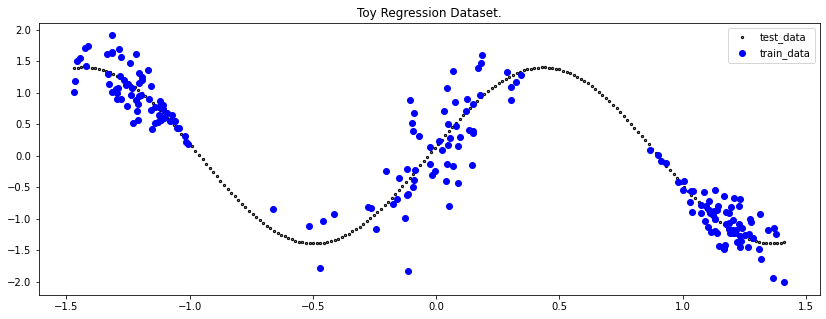

In [11]:
dm = ToyHeteroscedasticDatamodule(batch_size=32,)

X_train, Y_train, train_loader, X_test, Y_test, test_loader,  = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),

)

fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

In [12]:
# train the pre-conditioning model
network = MLP(n_inputs=1, n_hidden=[100, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer.fit(cond_mean_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmpq68z48nz/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 32.10it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 30.45it/s, v_num=0]


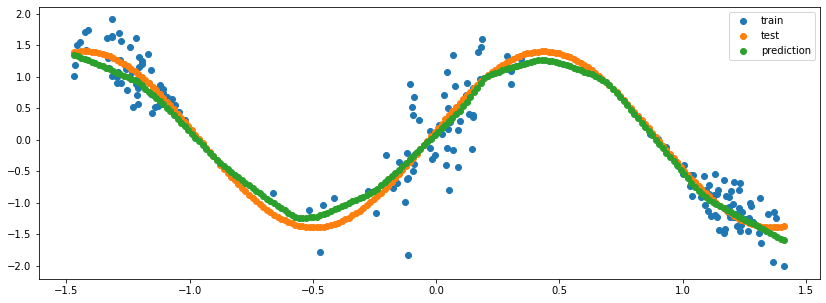

In [13]:
preds = cond_mean_model.predict_step(X_test)
fig, ax = plt.subplots(1)
ax.scatter(X_train, Y_train, label="train")
ax.scatter(X_test, Y_test, label="test")
ax.scatter(X_test, preds["pred"], label="prediction")
plt.legend()

In [14]:
# Conditional Diffusion
n_steps = 1000  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = 1
y_dim = 1

n_hidden = [128, 128]

beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)
card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
)



logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    early_stopping_patience=50,
)
diff_trainer.fit(card_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmpk1m6laj4/lightning_logs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 5.3 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|██████████| 7/7 [00:00<00:00, 52.70it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 7/7 [00:00<00:00, 52.43it/s, v_num=0]


In [15]:
card_model = card_model.to("cpu")
preds_1 = card_model.predict_step(X_test.cpu())
preds_2 = card_model.predict_step(X_test.cpu())
preds_3 = card_model.predict_step(X_test.cpu())
preds_4 = card_model.predict_step(X_test.cpu())
preds_5 = card_model.predict_step(X_test.cpu())

# average the preds to get the final preds and pred_uct
preds = {
    "pred": torch.stack([preds_1["pred"], preds_2["pred"], preds_3["pred"], preds_4["pred"], preds_5["pred"]]).mean(0),
    "pred_uct": torch.stack([preds_1["pred_uct"], preds_2["pred_uct"], preds_3["pred_uct"], preds_4["pred_uct"], preds_5["pred_uct"]]).mean(0) + torch.stack([preds_1["pred"], preds_2["pred"], preds_3["pred"], preds_4["pred"], preds_5["pred"]]).std(0),
    "aleatoric_uct": torch.stack([preds_1["aleatoric_uct"], preds_2["aleatoric_uct"], preds_3["aleatoric_uct"], preds_4["aleatoric_uct"], preds_5["aleatoric_uct"]]).mean(0),
    "epistemic_uct": torch.stack([preds_1["pred"], preds_2["pred"], preds_3["pred"], preds_4["pred"], preds_5["pred"]]).std(0),
}

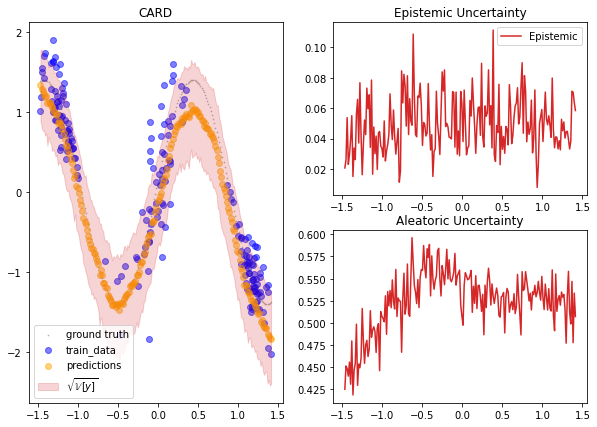

In [16]:
fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_test,
    Y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    epistemic=preds["epistemic_uct"],
    title="CARD",
    show_bands=False,
)

<Figure size 1008x360 with 0 Axes>

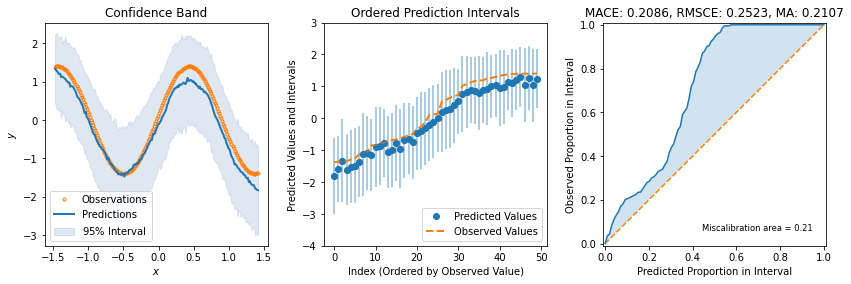

In [17]:

fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)

<h2> Conditional Diffusion for Xgas retrieval </h2>

In [67]:
seed_everything(0)  # seed everything for reproducibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device
my_temp_dir = tempfile.mkdtemp()

Seed set to 0


In [68]:
# FOR TESTING ONLY

# define a simple pytorch model that takes n_inputs, n_hidden, and n_outputs
class LinearMLP(nn.Module):
    """Simple Linear Neural Network"""
    def __init__(self, n_inputs: int, n_hidden: list[int], n_outputs: int):
        """Args:
            n_inputs: The number of input features
            n_hidden: The number of hidden units in each layer
            n_outputs: The number of output features
        """
        super().__init__()
        self.layers = nn.ModuleList()
        n_units = [n_inputs] + n_hidden + [n_outputs]
        for i in range(len(n_units) - 1):
            self.layers.append(nn.Linear(n_units[i], n_units[i + 1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x
    

class NonlinearMLP(nn.Module):
    """Simple Nonlinear Neural Network"""
    def __init__(self, n_inputs: int, n_hidden: list[int], n_outputs: int, activation: nn.Module):
        super().__init__()
        """Args:
            n_inputs: The number of input features
            n_hidden: The number of hidden units in each layer
            n_outputs: The number of output features
            activation: The nonlinear activation function
        """
        self.layers = nn.ModuleList()
        self.activation = activation
        n_units = [n_inputs] + n_hidden + [n_outputs]
        layers = []
        for i in range(len(n_units) - 1):
            layers.append(nn.Linear(n_units[i], n_units[i + 1]))
            if i < len(n_units) - 2:
                layers.append(self.activation)
                layers.append(nn.Dropout(0.01))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x
    

class Conv1DNN(nn.Module):
    '''
        Simple Conv1D Neural Network
    '''
    def __init__(self, n_inputs: int, n_hidden: list[int], n_outputs: int, pool_size: int,activation: nn.Module):
        super().__init__()
        """Args:
            n_inputs: The number of input features
            n_hidden: The number of hidden units in each layer
            n_outputs: The number of output features
            pool_size: The size of the pooling layer
            activation: The nonlinear activation function
        """
        self.layers = nn.ModuleList()
        self.activation = activation
        n_units = [n_inputs] + n_hidden + [n_outputs]
        layers = []
        for i in range(len(n_units) - 2):
            layers.append(nn.Conv1d(n_units[i], n_units[i + 1], 3))
            layers.append(self.activation)
            layers.append(nn.MaxPool1d(pool_size))
            layers.append(nn.Dropout(0.1))

        # linear output layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(n_units[-2], n_units[-1]))

        self.layers = nn.Sequential(*layers)
  
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x
    




    

    




In [85]:
class SimDiffAE(nn.Module):
    '''
        Simple AutoEncoder
    '''
    def __init__(self, n_inputs: int, n_hidden: list[int], n_outputs: int, activation: nn.Module):
        super().__init__()
        """Args:
            n_inputs: The number of input features
            n_hidden: The number of hidden units in each layer
            latent: The number of latent features
            n_outputs: The number of output features
            activation: The nonlinear activation function
        """
        self.encoder = nn.Sequential(
            nn.Linear(n_inputs, n_hidden[0]),
            activation,
            nn.Linear(n_hidden[0], n_hidden[1]),
            activation,
            nn.Linear(n_hidden[1], n_hidden[2]),
            activation,
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_hidden[2], n_hidden[1]),
            activation,
            nn.Linear(n_hidden[1], n_hidden[0]),
            activation,
            nn.Linear(n_hidden[0], n_outputs),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

class SimDiffConvAE(nn.Module):
    '''
        Simple Conv1D AutoEncoder
    '''
    def __init__(self, n_inputs: int, n_hidden: list[int], n_outputs: int, pool_size: int, activation: nn.Module):
        super().__init__()
        """Args:
            n_inputs: The number of input features
            n_hidden: The number of hidden units in each layer
            n_outputs: The number of output features
            pool_size: The size of the pooling layer
            activation: The nonlinear activation function
        """
        self.encoder = nn.Sequential(
            nn.Conv1d(n_inputs, n_hidden[0], 3),
            activation,
            # nn.MaxPool1d(pool_size),
            nn.Conv1d(n_hidden[0], n_hidden[1], 3),
            activation,
            # nn.MaxPool1d(pool_size),
            nn.Conv1d(n_hidden[1], n_hidden[2], 3),
            activation,
            nn.MaxPool1d(pool_size),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(n_hidden[2], n_hidden[1], 3),
            activation,
            # nn.Upsample(scale_factor=pool_size),
            nn.ConvTranspose1d(n_hidden[1], n_hidden[0], 3),
            activation,
            # nn.Upsample(scale_factor=pool_size),
            nn.ConvTranspose1d(n_hidden[0], n_outputs, 3),

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


class SimDiffUNet1D(nn.Module):
    def __init__(self, n_features: int, n_filters: int = 64, n_outputs: int = 1, pool_size: int = 2, activation: nn.Module = nn.ReLU()):
        super(SimDiffUNet1D, self).__init__()
        self.n_features = n_features
        self.n_filters = n_filters
        self.n_outputs = n_outputs
        self.pool_size = pool_size
        self.activation = activation

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv1d(n_features, n_filters, kernel_size=3, padding=1),
            activation,
            nn.MaxPool1d(pool_size)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(n_filters, n_filters * 2, kernel_size=3, padding=1),
            activation,
            nn.MaxPool1d(pool_size)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(n_filters * 2, n_filters * 4, kernel_size=3, padding=1),
            activation,
            nn.MaxPool1d(pool_size)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(n_filters * 4, n_filters * 8, kernel_size=3, padding=1),
            activation
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose1d(n_filters * 8, n_filters * 4, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv1d(n_filters * 8, n_filters * 4, kernel_size=3, padding=1),
            activation
        )
        self.upconv2 = nn.ConvTranspose1d(n_filters * 4, n_filters * 2, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv1d(n_filters * 4, n_filters * 2, kernel_size=3, padding=1),
            activation
        )
        self.upconv3 = nn.ConvTranspose1d(n_filters * 2, n_filters, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv1d(n_filters * 2, n_filters, kernel_size=3, padding=1),
            activation
        )

        # Output layer
        self.output_conv = nn.Conv1d(n_filters, n_outputs, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.encoder1(x)
        c2 = self.encoder2(c1)
        c3 = self.encoder3(c2)

        # Bottleneck
        b = self.bottleneck(c3)

        # Decoder
        u1 = self._pad_to_match(self.upconv1(b), c3)
        concat1 = torch.cat([u1, c3], dim=1)
        d1 = self.decoder1(concat1)

        u2 = self._pad_to_match(self.upconv2(d1), c2)
        concat2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(concat2)

        u3 = self._pad_to_match(self.upconv3(d2), c1)
        concat3 = torch.cat([u3, c1], dim=1)
        d3 = self.decoder3(concat3)

        # Output
        outputs = self.output_conv(d3)
        return outputs

    def _pad_to_match(self, x, ref):
        """Pads tensor x to match the shape of tensor ref"""
        diff = ref.size(2) - x.size(2)
        if diff > 0:
            x = torch.nn.functional.pad(x, (0, diff))
        elif diff < 0:
            x = x[:, :, :ref.size(2)]
        return x

    





#TODO : Get UNET working! Make sure that the datamaodule and dataset unsqueeze X and y correctly.
class SimDiffTrainer(pl.LightningModule):
    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, use_convolutions: bool = False,):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.use_convolutions = use_convolutions

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["input"], batch["target"]
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["input"], batch["target"]
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch["input"], batch["target"]
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer




In [84]:
pkl_str = "/Users/williamkeely/Desktop/Fast_Retrieval/Data/L2DiaND_XCO2_2020_downsampled_eof_removed_aligned_local.p"
train_files = [pkl_str]
test_files = [pkl_str]

dm_sco2 = SimDiffDataModule('sco2',train_files,train_files,train_files,batch_size=32, use_convolutions=True)
dm_wco2 = SimDiffDataModule('wco2',train_files,train_files,train_files,batch_size=32, use_convolutions=True)
dm_o2 = SimDiffDataModule('o2',train_files,train_files,train_files,batch_size=32, use_convolutions=True)
X_train_sco2, Y_train_sco2, train_loader_sco2, X_test_sco2, Y_test_sco2, test_loader_sco2,  = (
    dm_sco2.X_train,
    dm_sco2.Y_train,
    dm_sco2.train_dataloader(),
    dm_sco2.X_test,
    dm_sco2.Y_test,
    dm_sco2.test_dataloader(),

)
X_train_wco2, Y_train_wco2, train_loader_wco2, X_test_wco2, Y_test_wco2, test_loader_wco2,  = (
    dm_wco2.X_train,
    dm_wco2.Y_train,
    dm_wco2.train_dataloader(),
    dm_wco2.X_test,
    dm_wco2.Y_test,
    dm_wco2.test_dataloader(),

)
X_train_o2, Y_train_o2, train_loader_o2, X_test_o2, Y_test_o2, test_loader_o2,  = (
    dm_o2.X_train,
    dm_o2.Y_train,
    dm_o2.train_dataloader(),
    dm_o2.X_test,
    dm_o2.Y_test,
    dm_o2.test_dataloader(),

)

# train an autoencoder for each band
# o2
# model_o2 = SimDiffAE(n_inputs=X_train_o2.shape[1], n_hidden=[256, 256, 512],  n_outputs=Y_train_o2.shape[1], activation=nn.Sigmoid())
# model_o2 = SimDiffConvAE(n_inputs=X_train_o2.shape[1], n_hidden=[256, 128, 64], n_outputs=Y_train_o2.shape[1], pool_size=2, activation=nn.LeakyReLU())
model_o2 = SimDiffUNet1D(n_features=X_train_o2.shape[1], n_filters=64, n_outputs=1, pool_size=2, activation=nn.LeakyReLU())
cond_mean_model_o2 = SimDiffTrainer(model_o2, torch.optim.Adam(model_o2.parameters(), lr=1e-6), nn.MSELoss(), use_convolutions=True)
trainer_o2 = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer_o2.fit(cond_mean_model_o2, train_loader_o2)

# wco2
# model_wco2 = SimDiffAE(n_inputs=X_train_wco2.shape[1], n_hidden=[256, 256, 128],  n_outputs=Y_train_wco2.shape[1], activation=nn.Sigmoid())
# model_wco2 = SimDiffConvAE(n_inputs=X_train_wco2.shape[1], n_hidden=[256, 128, 64], n_outputs=Y_train_wco2.shape[1], pool_size=2, activation=nn.LeakyReLU())
model_wco2 = SimDiffUNet1D(n_features=X_train_wco2.shape[1], n_filters=64, n_outputs=1, pool_size=2, activation=nn.LeakyReLU())
cond_mean_model_wco2 = SimDiffTrainer(model_wco2, torch.optim.Adam(model_wco2.parameters(), lr=1e-4), nn.MSELoss(), use_convolutions=True)
trainer_wco2 = Trainer(
    max_epochs=200,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer_wco2.fit(cond_mean_model_wco2, train_loader_wco2)

# sco2
# model_sco2 = SimDiffAE(n_inputs=X_train_sco2.shape[1], n_hidden=[256, 256, 128], n_outputs=Y_train_sco2.shape[1], activation=nn.Sigmoid())
# model_sco2 = SimDiffConvAE(n_inputs=X_train_sco2.shape[1], n_hidden=[256, 128, 64], n_outputs=Y_train_sco2.shape[1], pool_size=2, activation=nn.LeakyReLU())
model_sco2 = SimDiffUNet1D(n_features=X_train_sco2.shape[1], n_filters=64, n_outputs=1, pool_size=2, activation=nn.LeakyReLU())
cond_mean_model_sco2 = SimDiffTrainer(model_sco2, torch.optim.Adam(model_sco2.parameters(), lr=1e-6), nn.MSELoss(), use_convolutions=True)
trainer_sco2 = Trainer(
    max_epochs=200,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer_sco2.fit(cond_mean_model_sco2, train_loader_sco2)




# open the sim_diff_normalize.pkl file and load the normalization parameters
with open('sim_diff_normalize.pkl', 'rb') as file:
    norm_params = pickle.load(file)
y_o2_mean = norm_params['y_o2_mean']
y_o2_std = norm_params['y_o2_std']
y_wco2_mean = norm_params['y_wco2_mean']
y_wco2_std = norm_params['y_wco2_std']
y_sco2_mean = norm_params['y_sco2_mean']
y_sco2_std = norm_params['y_sco2_std']

# make predictions for each band
preds_o2 = cond_mean_model_o2.predict_step(X_test_o2)
preds_wco2 = cond_mean_model_wco2.predict_step(X_test_wco2)
preds_sco2 = cond_mean_model_sco2.predict_step(X_test_sco2)

# unscale the predictions
pred_o2 = preds_o2.detach().numpy() * y_o2_std + y_o2_mean
pred_wco2 = preds_wco2.detach().numpy() * y_wco2_std + y_wco2_mean
pred_sco2 = preds_sco2.detach().numpy() * y_sco2_std + y_sco2_mean

# unscale the true values
Y_test_o2_unnormed = Y_test_o2.numpy() * y_o2_std + y_o2_mean
Y_test_wco2_unnormed = Y_test_wco2.numpy() * y_wco2_std + y_wco2_mean
Y_test_sco2_unnormed = Y_test_sco2.numpy() * y_sco2_std + y_sco2_mean


# append the predictions and the true values
preds = np.concatenate([pred_o2, pred_wco2, pred_sco2], axis=1)
Y_test = np.concatenate([Y_test_o2_unnormed, Y_test_wco2_unnormed, Y_test_sco2_unnormed], axis=1)





torch.Size([3351, 1, 632])
torch.Size([3351, 1, 632])
torch.Size([3351, 1, 632])
torch.Size([3351, 1, 632])
torch.Size([3351, 1, 512])
torch.Size([3351, 1, 512])
torch.Size([3351, 1, 512])
torch.Size([3351, 1, 512])
torch.Size([3351, 1, 720])
torch.Size([3351, 1, 720])
torch.Size([3351, 1, 720])
torch.Size([3351, 1, 720])


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmp8vhzdzpt/lightning_logs

  | Name    | Type          | Params
------------------------------------------
0 | model   | SimDiffUNet1D | 1.4 M 
1 | loss_fn | MSELoss       | 0     
------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.513     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/105 [00:00<?, ?it/s] 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 180 but got size 90 for tensor number 1 in the list.

torch.Size([3617, 771])
torch.Size([3617, 771])
torch.Size([3617, 771])
torch.Size([3617, 612])
torch.Size([3617, 612])
torch.Size([3617, 612])
torch.Size([3617, 804])
torch.Size([3617, 804])
torch.Size([3617, 804])


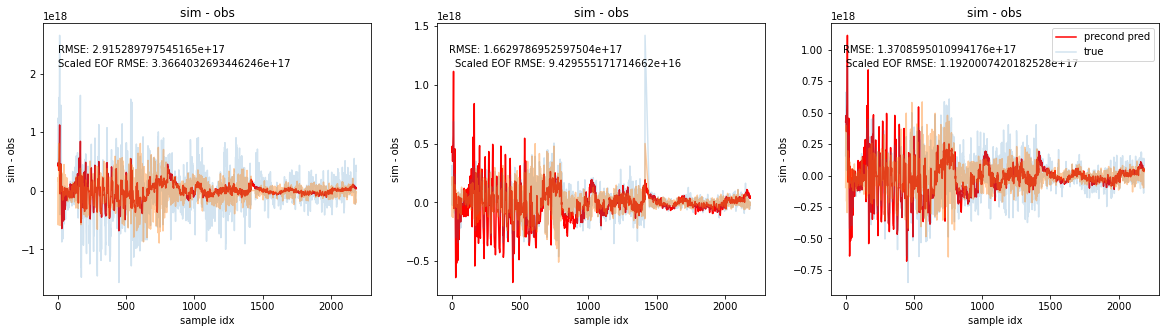

In [16]:
# load dms for scaled_eof
dm_sco2_scaled = SimDiffDataModule('sco2',train_files,train_files,train_files,batch_size=32, use_convolutions=False, scaled_eof=True)
dm_wco2_scaled = SimDiffDataModule('wco2',train_files,train_files,train_files,batch_size=32, use_convolutions=False, scaled_eof=True)
dm_o2_scaled = SimDiffDataModule('o2',train_files,train_files,train_files,batch_size=32, use_convolutions=False, scaled_eof=True)

X_train_scaled_eof_sco2, Y_train_scaled_eof_sco2, train_loader_scaled_eof_sco2, X_test_scaled_eof_sco2, Y_test_scaled_eof_sco2, test_loader_scaled_eof_sco2,  = (
    dm_sco2_scaled.X_train,
    dm_sco2_scaled.Y_train,
    dm_sco2_scaled.train_dataloader(),
    dm_sco2_scaled.X_test,
    dm_sco2_scaled.Y_test,
    dm_sco2_scaled.test_dataloader(),
)
X_train_scaled_eof_wco2, Y_train_scaled_eof_wco2, train_loader_scaled_eof_wco2, X_test_scaled_eof_wco2, Y_test_scaled_eof_wco2, test_loader_scaled_eof_wco2,  = (
    dm_wco2_scaled.X_train,
    dm_wco2_scaled.Y_train,
    dm_wco2_scaled.train_dataloader(),
    dm_wco2_scaled.X_test,
    dm_wco2_scaled.Y_test,
    dm_wco2_scaled.test_dataloader(),
)
X_train_scaled_eof_o2, Y_train_scaled_eof_o2, train_loader_scaled_eof_o2, X_test_scaled_eof_o2, Y_test_scaled_eof_o2, test_loader_scaled_eof_o2,  = (
    dm_o2_scaled.X_train,
    dm_o2_scaled.Y_train,
    dm_o2_scaled.train_dataloader(),
    dm_o2_scaled.X_test,
    dm_o2_scaled.Y_test,
    dm_o2_scaled.test_dataloader(),
)
# load the scaled_eof normalization parameters
with open('scaled_eof_sim_diff_normalize.pkl', 'rb') as file:
    norm_params_scaled_eof = pickle.load(file)
y_o2_mean_scaled_eof = norm_params_scaled_eof['y_o2_mean']
y_o2_std_scaled_eof = norm_params_scaled_eof['y_o2_std']
y_wco2_mean_scaled_eof = norm_params_scaled_eof['y_wco2_mean']
y_wco2_std_scaled_eof = norm_params_scaled_eof['y_wco2_std']
y_sco2_mean_scaled_eof = norm_params_scaled_eof['y_sco2_mean']
y_sco2_std_scaled_eof = norm_params_scaled_eof['y_sco2_std']

# unnorm the scaled_eof data
Y_test_o2_unnormed_scaled_eof = Y_test_scaled_eof_o2.numpy() * y_o2_std_scaled_eof + y_o2_mean_scaled_eof
Y_test_wco2_unnormed_scaled_eof = Y_test_scaled_eof_wco2.numpy() * y_wco2_std_scaled_eof + y_wco2_mean_scaled_eof
Y_test_sco2_unnormed_scaled_eof = Y_test_scaled_eof_sco2.numpy() * y_sco2_std_scaled_eof + y_sco2_mean_scaled_eof

# concatenate the unnormed data
Y_test_unnormed_scaled_eof = np.concatenate([Y_test_o2_unnormed_scaled_eof, Y_test_wco2_unnormed_scaled_eof, Y_test_sco2_unnormed_scaled_eof], axis=1)



# plot the X and the y from SimDiffDataSet
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(preds[0], c = 'r')
ax[0].plot(Y_test[0], alpha=0.2)
ax[0].plot(Y_test_unnormed_scaled_eof[0], alpha=0.4)
ax[0].set_xlabel("sample idx")
ax[0].set_ylabel("sim - obs")
ax[0].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax
reconstruction_loss = np.sqrt(np.mean((preds[0] - Y_test[0])**2))
ax[0].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[0] - Y_test[0])**2))
ax[0].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)





ax[1].plot(preds[500], c = 'r')
ax[1].plot(Y_test[500], alpha=0.2)  
ax[1].plot(Y_test_unnormed_scaled_eof[500], alpha=0.4) 
ax[1].set_xlabel("sample idx")
ax[1].set_ylabel("sim - obs")
ax[1].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax
reconstruction_loss = np.sqrt(np.mean((preds[500] - Y_test[500])**2))
ax[1].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[500] - Y_test[500])**2))
ax[1].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)


ax[2].plot(preds[3000], c = 'r')
ax[2].plot(Y_test[3000], alpha=0.2)
ax[2].plot(Y_test_unnormed_scaled_eof[3000], alpha=0.4)
ax[2].set_xlabel("sample idx")
ax[2].set_ylabel("sim - obs")
ax[2].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax as Reconstruction Loss and round to 2 decimal places
reconstruction_loss = np.sqrt(np.mean((preds[3000] - Y_test[3000])**2))
ax[2].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[3000] - Y_test[3000])**2))
ax[2].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)


# legend should show the red line as the pre-conditioning prediction and the alpha 0.2 line as the true value
plt.legend(["precond pred", "true"])



plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | SimDiffAE                    | 807 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 2.2 M 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.983    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 43.36it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 43.35it/s, v_num=4]


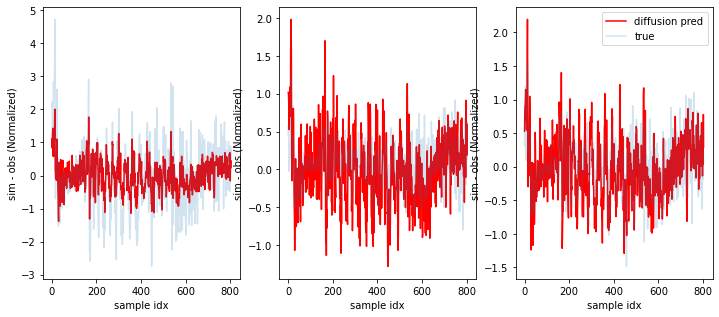

In [21]:


# Conditional Diffusion
n_steps = 10  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim_o2 = X_train_o2.shape[1]
y_dim_o2 = Y_train_o2.shape[1]

n_hidden = [512, 512,512]
activation_fn = nn.LeakyReLU()

beta_schedule = "linear"
beta_start = 0.00001
beta_end = 0.0002

n_z_samples = 20


# for each band do conditional diffusion
# o2
guidance_model_o2 = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim_o2,
    y_dim=y_dim_o2,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
    activation_fn=activation_fn,
)
card_model_o2 = CARDRegression(
    cond_mean_model=cond_mean_model_o2.model,
    guidance_model=guidance_model_o2,
    guidance_optim=partial(torch.optim.Adam, lr=1e-6),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
    n_z_samples=n_z_samples,
)
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    logger=logger,
    log_every_n_steps=10,
)

diff_trainer.fit(card_model_o2, dm_o2)

# plot the predictions and the true values
# plot the predictions and the true values
preds_o2 = card_model_o2.predict_step(X_test_o2.cpu())
preds_o2 = preds_o2["pred"].detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(preds_o2[0], c = 'r')
ax[0].plot(Y_test_o2[0], alpha=0.2)
ax[0].set_xlabel("sample idx")
ax[0].set_ylabel("sim - obs (Normalized)")

ax[1].plot(preds_o2[500], c = 'r')
ax[1].plot(Y_test_o2[500], alpha=0.2)
ax[1].set_xlabel("sample idx")
ax[1].set_ylabel("sim - obs (Normalized)")

ax[2].plot(preds_o2[3000], c = 'r')
ax[2].plot(Y_test_o2[3000], alpha=0.2)
ax[2].set_xlabel("sample idx")
ax[2].set_ylabel("sim - obs (Normalized)")

plt.legend(["diffusion pred", "true"])
plt.show()




GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | SimDiffAE                    | 511 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 2.1 M 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.462    Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 42.63it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 42.62it/s, v_num=9]


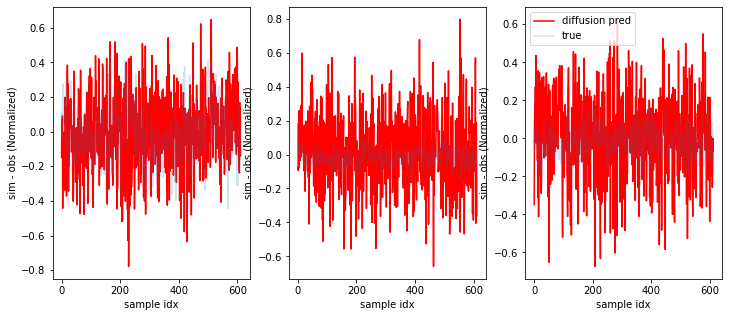

In [28]:


# Conditional Diffusion
n_steps = 30  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim_wco2 = X_train_wco2.shape[1]
y_dim_wco2 = Y_train_wco2.shape[1]

n_hidden = [512,512,512,512]
activation_fn = nn.Sigmoid()

beta_schedule = "linear"
beta_start = 0.00000001
beta_end = 0.000002

n_z_samples = 20
# wco2
guidance_model_wco2 = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim_wco2,
    y_dim=y_dim_wco2,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
    activation_fn=activation_fn,
)
card_model_wco2 = CARDRegression(
    cond_mean_model=cond_mean_model_wco2.model,
    guidance_model=guidance_model_wco2,
    guidance_optim=partial(torch.optim.Adam, lr=1e-6),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
    n_z_samples=n_z_samples,

)
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    logger=logger,
    log_every_n_steps=10,
)

diff_trainer.fit(card_model_wco2, dm_wco2)

# plot the predictions and the true values
preds_wco2 = card_model_wco2.predict_step(X_test_wco2.cpu())
preds_wco2 = preds_wco2["pred"].detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(preds_wco2[0], c = 'r')
ax[0].plot(Y_test_wco2[0], alpha=0.2)
ax[0].set_xlabel("sample idx")
ax[0].set_ylabel("sim - obs (Normalized)")

ax[1].plot(preds_wco2[500], c = 'r')
ax[1].plot(Y_test_wco2[500], alpha=0.2)
ax[1].set_xlabel("sample idx")
ax[1].set_ylabel("sim - obs (Normalized)")

ax[2].plot(preds_wco2[3000], c = 'r')
ax[2].plot(Y_test_wco2[3000], alpha=0.2)
ax[2].set_xlabel("sample idx")
ax[2].set_ylabel("sim - obs (Normalized)")

plt.legend(["diffusion pred", "true"])
plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | SimDiffAE                    | 593 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 2.1 M 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.857    Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 42.55it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 114/114 [00:02<00:00, 42.54it/s, v_num=6]


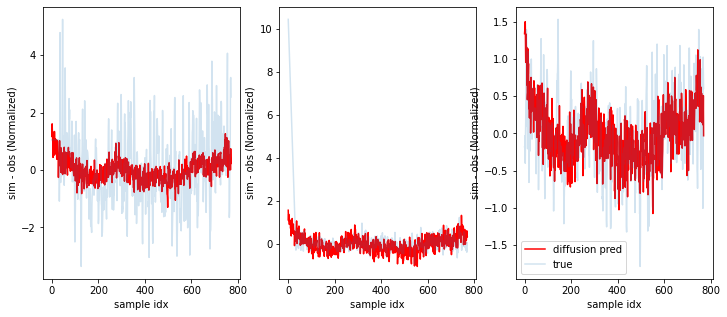

In [23]:


# Conditional Diffusion
n_steps = 10  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim_sco2 = X_train_sco2.shape[1]
y_dim_sco2 = Y_train_sco2.shape[1]

n_hidden = [512, 512, 512]
activation_fn = nn.LeakyReLU()

beta_schedule = "linear"
beta_start = 0.0000001
beta_end = 0.00002

n_z_samples = 20
# sco2
guidance_model_sco2 = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim_sco2,
    y_dim=y_dim_sco2,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
    activation_fn=activation_fn,
)
card_model_sco2 = CARDRegression(
    cond_mean_model=cond_mean_model_sco2.model,
    guidance_model=guidance_model_sco2,
    guidance_optim=partial(torch.optim.Adam, lr=1e-6),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
    n_z_samples=n_z_samples,
)
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    logger=logger,
    log_every_n_steps=10,
)

diff_trainer.fit(card_model_sco2, dm_sco2)

# plot the predictions and the true values
preds_sco2 = card_model_sco2.predict_step(X_test_sco2.cpu())
preds_sco2 = preds_sco2["pred"].detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(preds_sco2[0], c = 'r')
ax[0].plot(Y_test_sco2[0], alpha=0.2)
ax[0].set_xlabel("sample idx")
ax[0].set_ylabel("sim - obs (Normalized)")

ax[1].plot(preds_sco2[500], c = 'r')
ax[1].plot(Y_test_sco2[500], alpha=0.2)
ax[1].set_xlabel("sample idx")
ax[1].set_ylabel("sim - obs (Normalized)")

ax[2].plot(preds_sco2[3000], c = 'r')
ax[2].plot(Y_test_sco2[3000], alpha=0.2)
ax[2].set_xlabel("sample idx")
ax[2].set_ylabel("sim - obs (Normalized)")

plt.legend(["diffusion pred", "true"])
plt.show()



/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


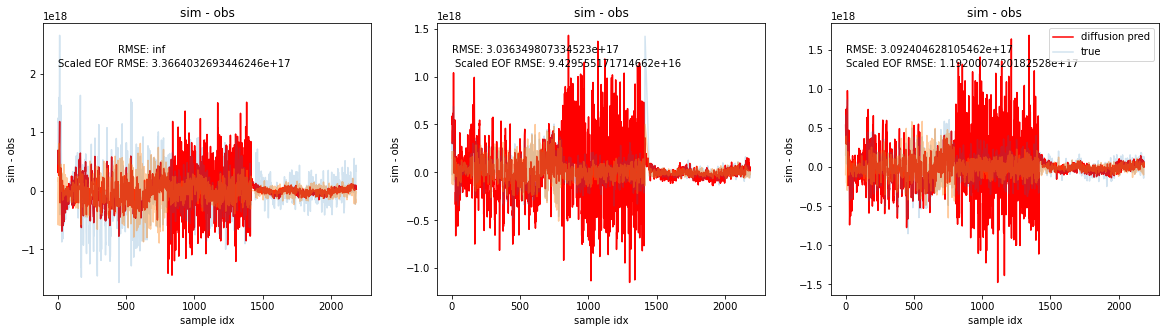

In [26]:
# open the sim_diff_normalize.pkl file and load the normalization parameters
with open('sim_diff_normalize.pkl', 'rb') as file:
    norm_params = pickle.load(file)
y_o2_mean = norm_params['y_o2_mean']
y_o2_std = norm_params['y_o2_std']
y_wco2_mean = norm_params['y_wco2_mean']
y_wco2_std = norm_params['y_wco2_std']
y_sco2_mean = norm_params['y_sco2_mean']
y_sco2_std = norm_params['y_sco2_std']

# make predictions for each band
preds_o2 = card_model_o2.predict_step(X_test_o2)
preds_wco2 = card_model_wco2.predict_step(X_test_wco2)
preds_sco2 = card_model_sco2.predict_step(X_test_sco2)

# unscale the predictions
pred_o2 = preds_o2["pred"].detach().numpy() * y_o2_std + y_o2_mean
pred_wco2 = preds_wco2["pred"].detach().numpy() * y_wco2_std + y_wco2_mean
pred_sco2 = preds_sco2["pred"].detach().numpy() * y_sco2_std + y_sco2_mean

# unscale the true values
Y_test_o2_unnormed = Y_test_o2.numpy() * y_o2_std + y_o2_mean
Y_test_wco2_unnormed = Y_test_wco2.numpy() * y_wco2_std + y_wco2_mean
Y_test_sco2_unnormed = Y_test_sco2.numpy() * y_sco2_std + y_sco2_mean

# append the predictions and the true values
preds = np.concatenate([pred_o2, pred_wco2, pred_sco2], axis=1)
Y_test = np.concatenate([Y_test_o2_unnormed, Y_test_wco2_unnormed, Y_test_sco2_unnormed], axis=1)
# plot the X and the y from SimDiffDataSet
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(preds[0], c = 'r')
ax[0].plot(Y_test[0], alpha=0.2)
ax[0].plot(Y_test_unnormed_scaled_eof[0], alpha=0.4)
ax[0].set_xlabel("sample idx")
ax[0].set_ylabel("sim - obs")
ax[0].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax
reconstruction_loss = np.sqrt(np.mean((preds[0] - Y_test[0])**2))
ax[0].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[0] - Y_test[0])**2))
ax[0].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

ax[1].plot(preds[500], c = 'r')
ax[1].plot(Y_test[500], alpha=0.2)
ax[1].plot(Y_test_unnormed_scaled_eof[500], alpha=0.4)
ax[1].set_xlabel("sample idx")
ax[1].set_ylabel("sim - obs")
ax[1].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax
reconstruction_loss = np.sqrt(np.mean((preds[500] - Y_test[500])**2))
ax[1].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[500] - Y_test[500])**2))
ax[1].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

ax[2].plot(preds[3000], c = 'r')
ax[2].plot(Y_test[3000], alpha=0.2)
ax[2].plot(Y_test_unnormed_scaled_eof[3000], alpha=0.4)
ax[2].set_xlabel("sample idx")
ax[2].set_ylabel("sim - obs")
ax[2].set_title("sim - obs")
# add RMSE as Reconstruction Loss on ax
reconstruction_loss = np.sqrt(np.mean((preds[3000] - Y_test[3000])**2))
ax[2].text(0.3, 0.9, f"RMSE: {reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
scaled_reconstruction_loss = np.sqrt(np.mean((Y_test_unnormed_scaled_eof[3000] - Y_test[3000])**2))
ax[2].text(0.4, 0.85, f"Scaled EOF RMSE: {scaled_reconstruction_loss}", horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)

# legend should show the red line as the pre-conditioning prediction and the alpha 0.2 line as the true value
plt.legend(["diffusion pred", "true"])

plt.show()


In [23]:
dm = RetrievalDataModule(train_files=train_files,val_files=train_files, test_files=test_files, batch_size=16, use_convolutions = False, normalize_file='normalize.pkl')
X_train, Y_train, train_loader, X_val, Y_val, val_loader, X_test, Y_test, val_loader,  = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_val,
    dm.Y_val,
    dm.val_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),


)

print(X_train.shape)
# train the pre-conditioning model
# network = MLP(n_inputs=X_train.shape[1], n_hidden=[64,64], n_outputs=1)
# network = SimpleMLP(n_inputs=X_train.shape[1], n_hidden=[128, 64], n_outputs=1)
# network = Conv1DNN(n_inputs=X_train.shape[1], n_hidden=[128, 64], n_outputs=1, pool_size=2, activation=nn.ReLU())
network = NonlinearMLP(n_inputs=X_train.shape[1], n_hidden=[128, 128, 64], n_outputs=1, activation=nn.LeakyReLU())

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-5), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=50,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tempfile.mkdtemp(),
)
trainer.fit(cond_mean_model, dm)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmp4i857630/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | NonlinearMLP     | 304 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
304 K     Trainable params
0         Non-trainable params
304 K     Total params
1.220     Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 227/227 [00:06<00:00, 34.31it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 227/227 [00:06<00:00, 34.27it/s, v_num=0]


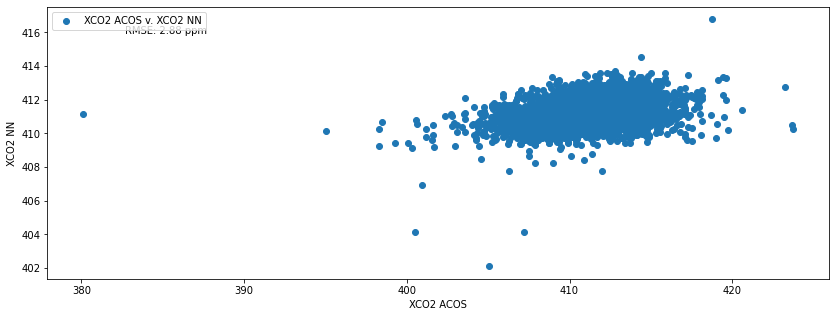

RMSE: 2.88 ppm


In [22]:
# plot preds from preconditioner
preds = cond_mean_model.predict_step(X_test)
Y_test = Y_test.squeeze()
# open the normalize.pkl file and gt y_std and y_mean
with open('normalize.pkl', 'rb') as file:
    norm_params = pickle.load(file)
Y_test_unnormed = Y_test * norm_params['targets_std'] + norm_params['targets_mean']
preds_unnormed = preds['pred'] * norm_params['targets_std'] + norm_params['targets_mean']
Y_test_unnormed = Y_test_unnormed * 1e6
preds_unnormed = preds_unnormed * 1e6
fig, ax = plt.subplots(1)
ax.scatter(Y_test_unnormed, preds_unnormed, label="XCO2 ACOS v. XCO2 NN")
ax.set_xlabel("XCO2 ACOS")
ax.set_ylabel("XCO2 NN")
# add the rmse to text
rmse = np.sqrt(np.mean((Y_test_unnormed.cpu().numpy() - preds_unnormed.cpu().numpy())**2))
ax.text(0.1, 0.9, f"RMSE: {rmse:.2f} ppm", transform=ax.transAxes)
plt.legend()
plt.show()
print(f"RMSE: {rmse:.2f} ppm")

In [18]:
# Conditional Diffusion
n_steps = 10  # number of diffusion steps
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = X_train.shape[1]
y_dim = 1

n_hidden = [512, 512, 512]

beta_schedule = "linear"
beta_start = 0.000001
beta_end = 0.0002
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
    activation_fn=nn.LeakyReLU(),
)
card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-5),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
)



logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train

)
diff_trainer.fit(card_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | NonlinearMLP                 | 288 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 1.7 M 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.803     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 227/227 [00:05<00:00, 45.00it/s, v_num=37]     

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 227/227 [00:05<00:00, 44.68it/s, v_num=37]


In [19]:
card_model = card_model.to("cpu")
preds = card_model.predict_step(X_test.cpu())

(3617,)
(3617,)
(3617,)
(3617, 2187)


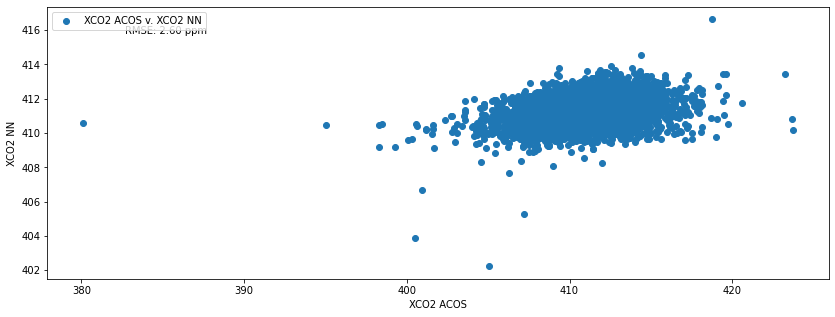

RMSE :  2.5953763


In [21]:
print(preds["pred"].cpu().numpy().shape)
print(preds["pred_uct"].cpu().numpy().shape)
print(Y_test.cpu().numpy().shape)
print(X_test.cpu().numpy().shape)


# open the normalize.pkl file and gt y_std and y_mean
with open('normalize.pkl', 'rb') as file:
    norm_params = pickle.load(file)
Y_test_unnormed = Y_test * norm_params['targets_std'] + norm_params['targets_mean']
preds_unnormed = preds['pred'] * norm_params['targets_std'] + norm_params['targets_mean']
Y_test_unnormed = Y_test_unnormed * 1e6
preds_unnormed = preds_unnormed * 1e6
fig, ax = plt.subplots(1)
ax.scatter(Y_test_unnormed, preds_unnormed, label="XCO2 ACOS v. XCO2 NN")
ax.set_xlabel("XCO2 ACOS")
ax.set_ylabel("XCO2 NN")
# add the rmse to text
rmse = np.sqrt(np.mean((Y_test_unnormed.cpu().numpy() - preds_unnormed.cpu().numpy())**2))
ax.text(0.1, 0.9, f"RMSE: {rmse:.2f} ppm", transform=ax.transAxes)
plt.legend()
plt.show()

print('RMSE : ', rmse)

In [93]:
Y_test

tensor([-0.5099, -0.0141, -0.2119,  ..., -0.0207,  1.2942, -0.5452])

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

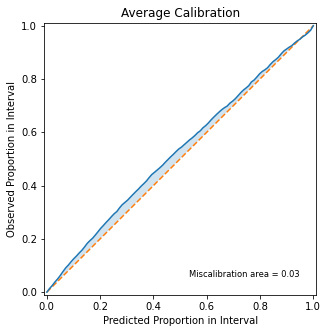

In [16]:
import uncertainty_toolbox as uct
# squeeze Y_test
Y_test = Y_test.squeeze()
uct.viz.plot_calibration(preds["pred"].cpu().numpy(), preds["pred_uct"].cpu().numpy(), Y_test.cpu().numpy())


<h2> Multiple Gaussians Inverse Problem </h2>

In [85]:

from lightning_uq_box.datamodules import Toy8GaussiansDataModule, ToyDonutDataModule


# dm = Toy8GaussiansDataModule(batch_size=256, n_samples=8096)
dm = ToyDonutDataModule(batch_size=256, n_samples=8096)

X_train, Y_train, train_loader, X_test, Y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

In [86]:
X_test.shape

torch.Size([3238, 1])

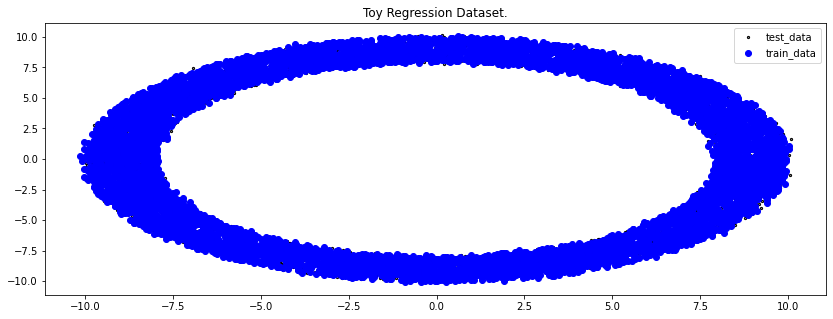

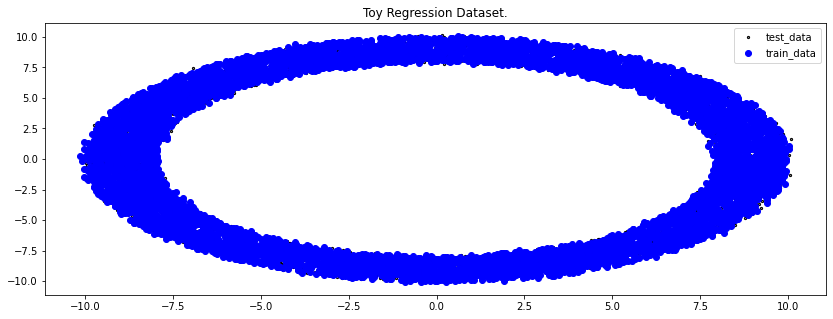

In [87]:
plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

In [88]:
another_temp_dir = tempfile.mkdtemp()
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
)
trainer.fit(cond_mean_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.7 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/williamkeely/miniconda3/envs/torch/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 53.27it/s, v_num=32]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 52.52it/s, v_num=32]


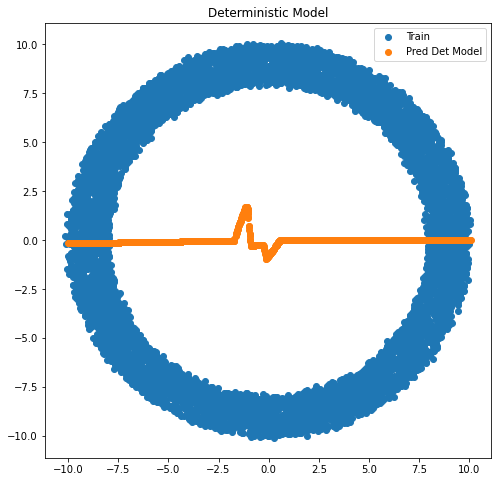

In [89]:
fig, axs = plt.subplots(1, figsize=(8, 8))

axs.scatter(X_train, Y_train, label="Train")
axs.scatter(
    X_test.detach().cpu().numpy(),
    network(X_test).detach().cpu().numpy(),
    label="Pred Det Model",
)
axs.set_title("Deterministic Model")
plt.legend()
plt.show()

In [90]:
# configuration parameters

n_steps = 1000
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = 1
y_dim = 1

n_hidden = [128, 128]

beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02

guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=[512, 512],
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    n_steps=n_steps,
)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logger = CSVLogger(another_temp_dir)
diff_trainer = Trainer(
    max_epochs=5000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=4,
    enable_progress_bar=True,
    limit_val_batches=0.0,
)
diff_trainer.fit(card_model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /var/folders/z6/vhr0xhx51s9bcs6y5nc2p7xr0000gn/T/tmpo3yu3pax/lightning_logs

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 1.3 M 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.168     Total estimated model params size (MB)


Epoch 4999: 100%|██████████| 32/32 [00:00<00:00, 73.59it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 32/32 [00:00<00:00, 70.02it/s, v_num=0]


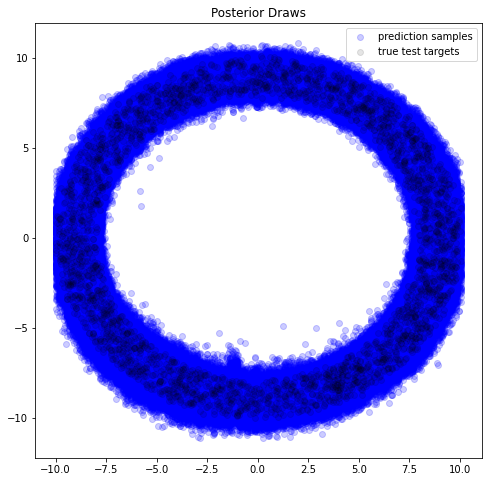

In [92]:
card_model = card_model.to("cpu")
preds = card_model.predict_step(X_test.cpu())

# samples of the last diffusion step which should recover the data distribution (n_samples, n_test_points, y_dim)
samples = preds["samples"][-1].detach().cpu().numpy()
fig, axs = plt.subplots(1, figsize=(8, 8))


axs.scatter(
    X_test.tile(dims=(card_model.n_z_samples, 1)),
    samples.squeeze(),
    alpha=0.2,
    color="blue",
    label="prediction samples",
)
axs.scatter(X_test, Y_test, label="true test targets", alpha=0.1, color="black")
axs.set_title("Posterior Draws")
plt.legend()


